In [1]:
import os

import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt

# 解壓縮資料

In [2]:
def unzip_data(path):
    for folder, _, files in os.walk(path):
        for file in files:
            if file.endswith('zip'):
                file_path = os.path.join(folder, file)
                print(file_path)

                sotre_path = os.path.join(folder, file.rsplit('.')[0])
                # 開啟 ZIP 壓縮檔 
                with zipfile.ZipFile(file_path, 'r') as zf:
                    # 解壓縮所有檔案至 /my/folder 目錄
                    zf.extractall(path=sotre_path)

In [3]:
# unzip_data('./swing')

In [4]:
def convert_csv(path):
    acc_df = pd.read_csv(os.path.join(path, 'Accelerometer.csv'), delimiter=',')
    gyo_df = pd.read_csv(os.path.join(path, 'Gyroscope.csv'), delimiter=',')
    linacc_df = pd.read_csv(os.path.join(path, 'Linear Accelerometer.csv'), delimiter=',')
    mag_df = pd.read_csv(os.path.join(path, 'Magnetometer.csv'), delimiter=',')
    device_df = pd.read_csv(os.path.join(path, 'meta', 'device.csv'), delimiter=',')
    time_df = pd.read_csv(os.path.join(path, 'meta', 'time.csv'), delimiter=',')
    
    acc_df.to_csv(os.path.join(path, 'Accelerometer.csv'), index=False, sep=';')
    gyo_df.to_csv(os.path.join(path, 'Gyroscope.csv'), index=False, sep=';')
    linacc_df.to_csv(os.path.join(path, 'Linear Accelerometer.csv'), index=False, sep=';')
    mag_df.to_csv(os.path.join(path, 'Magnetometer.csv'), index=False, sep=';')
    device_df.to_csv(os.path.join(path, 'meta', 'device.csv'), index=False, sep=';')
    time_df.to_csv(os.path.join(path, 'meta', 'time.csv'), index=False, sep=';')

In [5]:
# convert_csv('./pocket/202301101952/target')
# convert_csv('./pocket/202301101952/source')

# 讀檔

In [2]:
def rename_data(df):
    new_names = ['acc_times', 'acc_x', 'acc_y', 'acc_z', 'gyo_times', 'gyo_x', 'gyo_y', 'gyo_z', 'lin_acc_times', 'lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'mag_times', 'mag_x', 'mag_y', 'mag_z']
    df.columns = new_names
    
    return df


def load_original_data(path):
    acc_df = pd.read_csv(os.path.join(path, 'Accelerometer.csv'), delimiter=';')
    gyo_df = pd.read_csv(os.path.join(path, 'Gyroscope.csv'), delimiter=';')
    linacc_df = pd.read_csv(os.path.join(path, 'Linear Accelerometer.csv'), delimiter=';')
    mag_df = pd.read_csv(os.path.join(path, 'Magnetometer.csv'), delimiter=';')
    
    total_df = pd.concat([acc_df, gyo_df, linacc_df, mag_df], axis=1)
    total_df = rename_data(total_df)
    
    return total_df

In [3]:
def bound_range(df):
    start = datapoint_per_second * 30
    end = len(df) - datapoint_per_second * 30
    
    return df.iloc[start:end]


def split_segments(df, duration=5):
    length = datapoint_per_second * duration
    len_of_segs = int(np.floor(len(df) / length))
    
    segments = []
    for i in range(len_of_segs):
        segments.append(df.iloc[int(i * length):int((i + 1) * length)].to_numpy())
        
    return segments


def select_data(df):
    return df[['acc_x', 'acc_y', 'acc_z', 'gyo_x', 'gyo_y', 'gyo_z', 'lin_acc_x', 'lin_acc_y', 'lin_acc_z']]


def preprocess_data(df, duration):
    pre_df = bound_range(df)
    pre_df = select_data(pre_df)
    segs = split_segments(pre_df, duration)
    
    return segs

In [8]:
# test_df = load_original_data('./front_pocket/202302071724/source')
# segs = preprocess_data(test_df)

In [24]:
datapoint_per_second = 20
duration = 5
classes = {'target': 0, 'front_pocket': 1, 'pocket': 2, 'swing': 3}

def device_version(path):
    device_df = pd.read_csv(os.path.join(path, 'meta/device.csv'), delimiter=';', index_col=0)
    version = device_df.loc['deviceRelease'].value
    
    return version

def load_pair_data(root_folder, class_num):
    pair_data = []

    for folder in os.listdir(root_folder):
        if folder.startswith('.'):
            continue

        folder_path = os.path.join(root_folder, folder)
        source_path = os.path.join(folder_path, 'source')
        target_path = os.path.join(folder_path, 'target')
        
        print(folder_path)
        
        #########################
        ##### check devices #####
        #########################
        while True:
            source_version = device_version(source_path)
            target_version = device_version(target_path)
            
            print(source_path, target_path)
            
            if source_version[:2] == '15' and target_version[:2] == '16':
                break
            elif source_version[:2] == '16' and target_version[:2] == '15':
                source_path = os.path.join(folder_path, 'target')
                target_path = os.path.join(folder_path, 'source')
                print('--- GG ---')
                continue
            else:
                raise
        
        ####################################
        ##### load and preprocess data #####
        ####################################
        print('path: ', source_path, target_path)
        source_segs = preprocess_data(load_original_data(source_path), duration)
        target_segs = preprocess_data(load_original_data(target_path), duration)

        idx = min(len(source_segs), len(target_segs))
        source_tags = [class_num] * idx
        target_tags = [0] * idx

        pair_data.extend(zip(source_segs[:idx], source_tags, target_segs[:idx], target_tags))
        
    return pair_data

In [10]:
device_version('./front_pocket/202302071523/source')  # source version: 15.4

'15.4'

In [11]:
device_version('./front_pocket/202302071523/target')  # target version: 16.3

'16.3'

In [25]:
front_pocket_pair_data = load_pair_data('./front_pocket', class_num=1)
pocket_pair_data = load_pair_data('./pocket', class_num=2)
swing_pair_data = load_pair_data('./swing', class_num=3)

./front_pocket/202302071628
./front_pocket/202302071628/source ./front_pocket/202302071628/target
path:  ./front_pocket/202302071628/source ./front_pocket/202302071628/target
./front_pocket/202302071652
./front_pocket/202302071652/source ./front_pocket/202302071652/target
path:  ./front_pocket/202302071652/source ./front_pocket/202302071652/target
./front_pocket/202302071523
./front_pocket/202302071523/source ./front_pocket/202302071523/target
path:  ./front_pocket/202302071523/source ./front_pocket/202302071523/target
./front_pocket/202302071531
./front_pocket/202302071531/source ./front_pocket/202302071531/target
path:  ./front_pocket/202302071531/source ./front_pocket/202302071531/target
./front_pocket/202302071715
./front_pocket/202302071715/source ./front_pocket/202302071715/target
path:  ./front_pocket/202302071715/source ./front_pocket/202302071715/target
./front_pocket/202302071641
./front_pocket/202302071641/source ./front_pocket/202302071641/target
path:  ./front_pocket/20230

In [6]:
print(len(front_pocket_pair_data), len(pocket_pair_data), len(swing_pair_data))

565 536 526


In [34]:
label_name = ['acc_x', 'acc_y', 'acc_z', 'gyo_x', 'gyo_y', 'gyo_z', 'lin_acc_x', 'lin_acc_y', 'lin_acc_z']

def plot_curve(seq, title):
    plt.figure(figsize=(30, 5))
    X = np.arange(len(seq))
    
    for i in range(seq.shape[1]):
        plt.plot(X, seq[:, i], label=label_name[i])
        
    plt.legend()
    plt.title(title)
    plt.ylim(-15, 15)
    plt.plot()

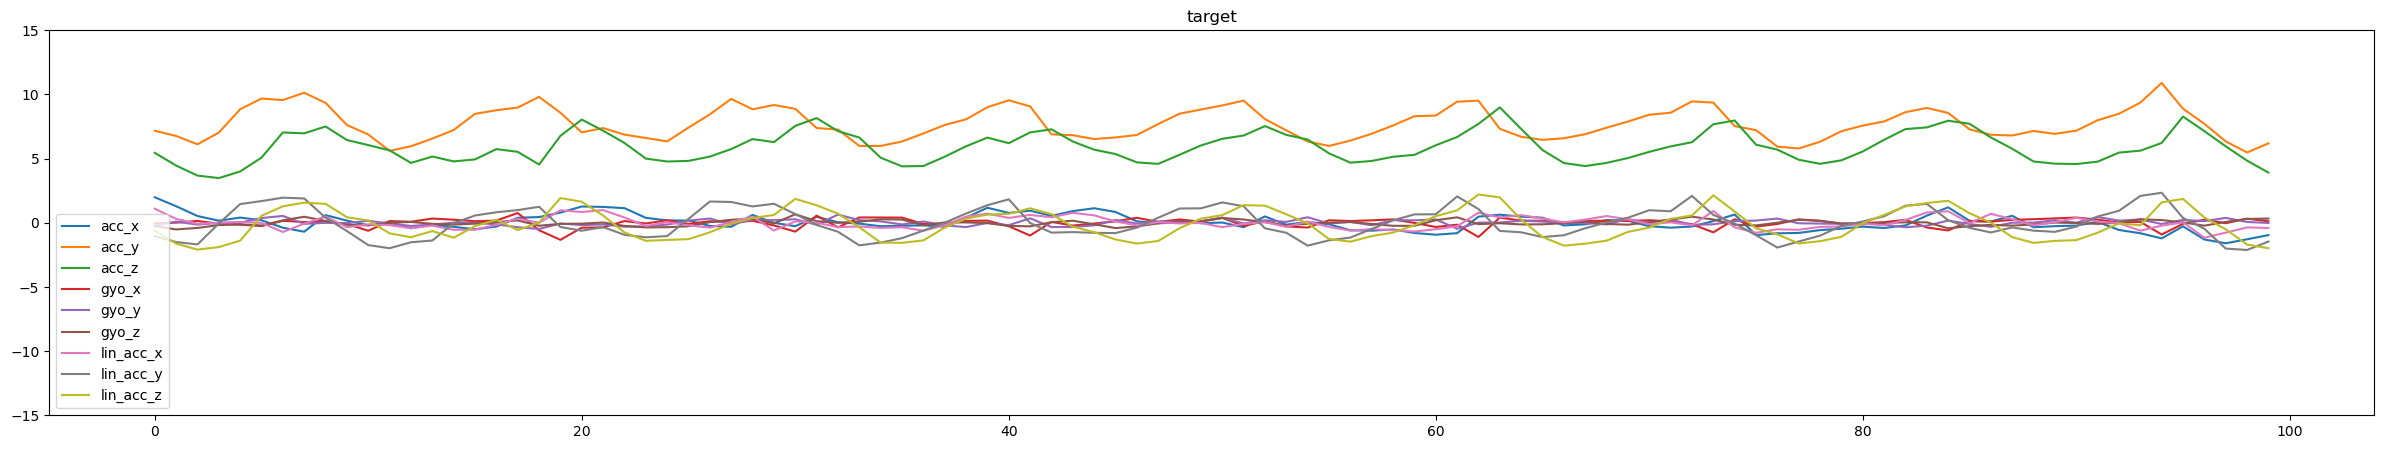

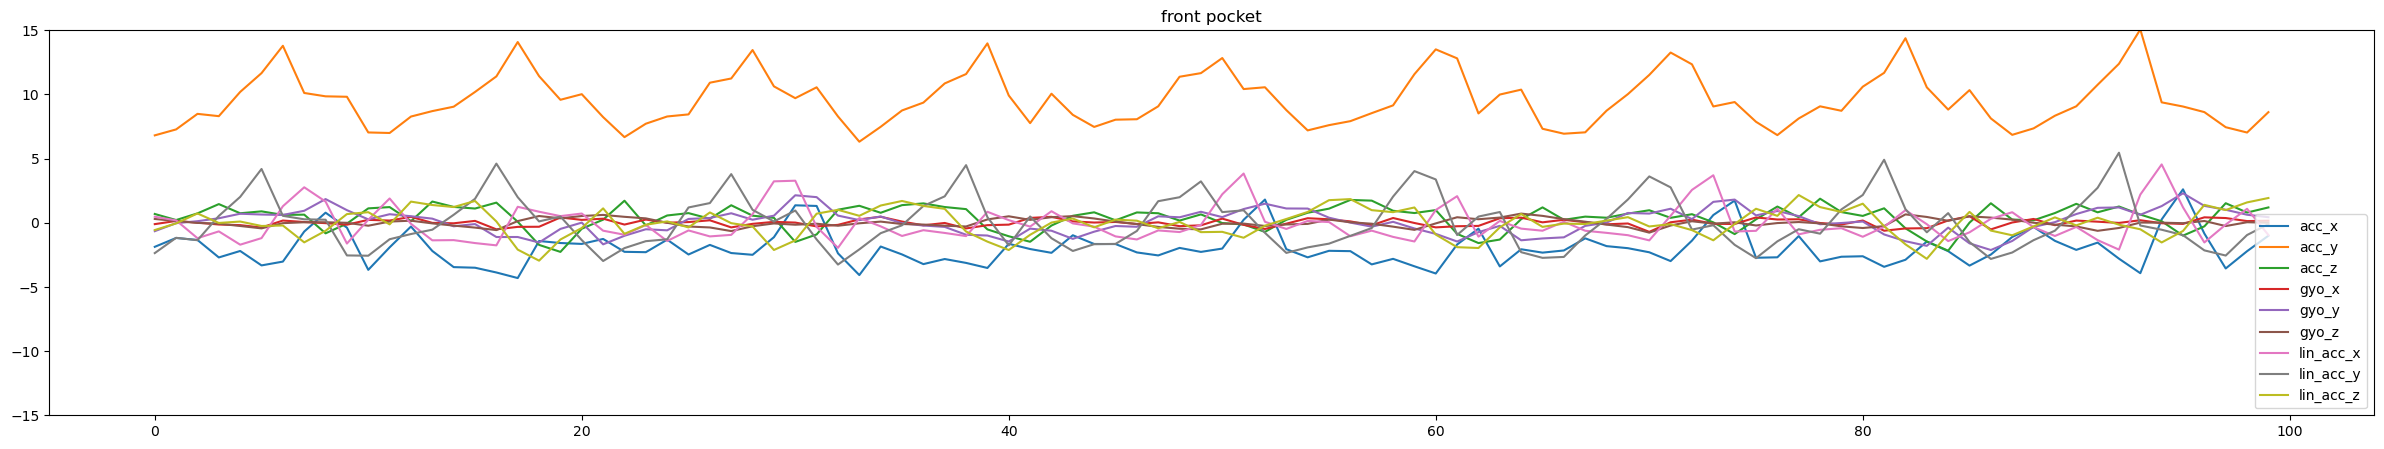

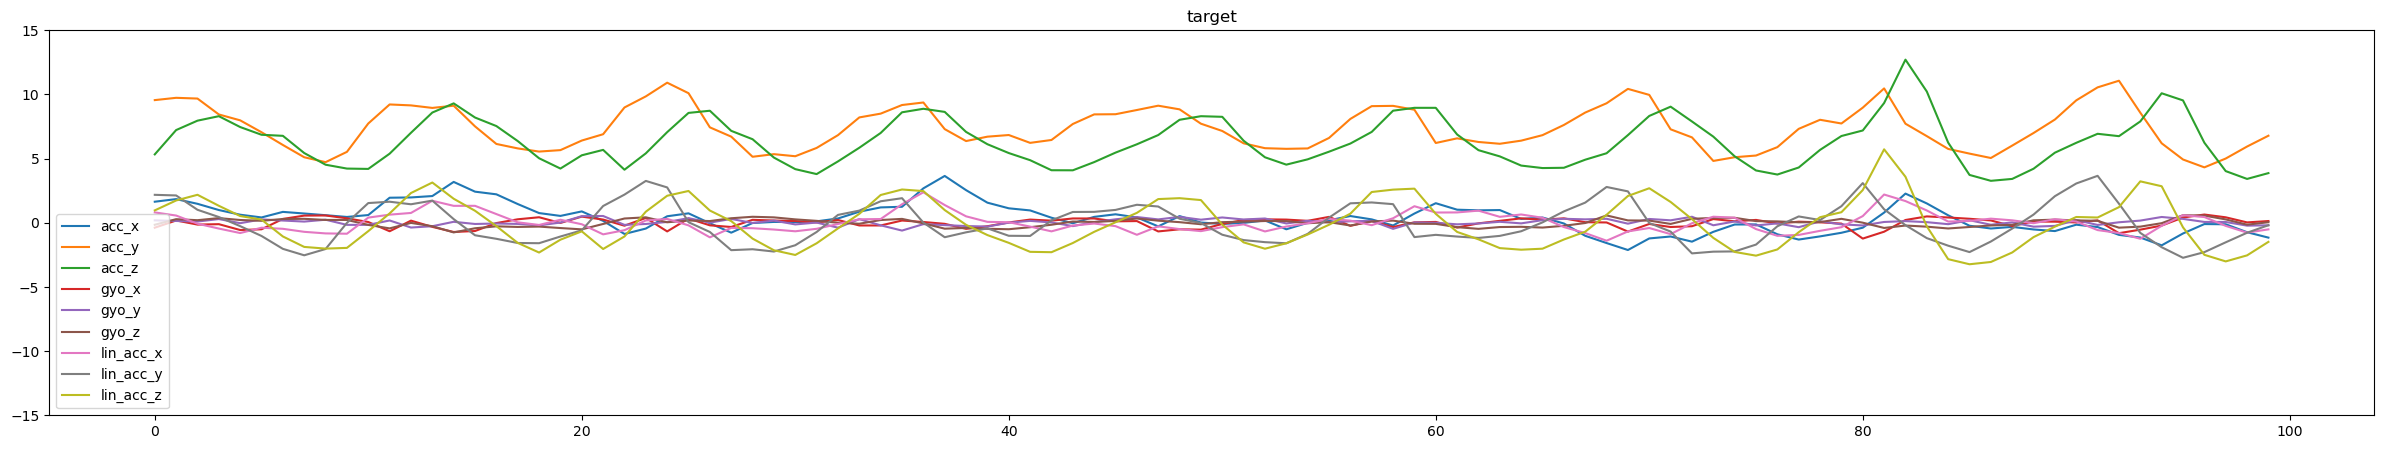

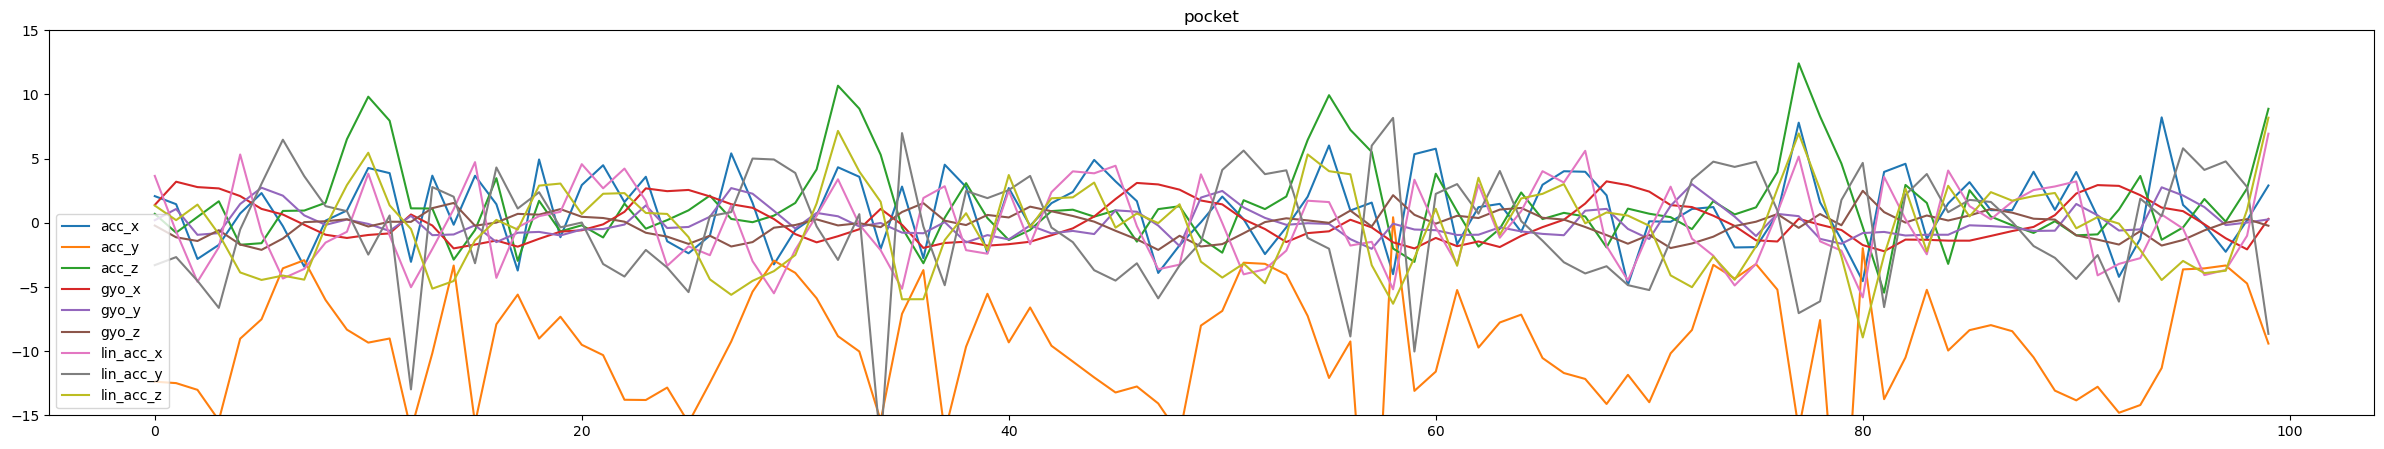

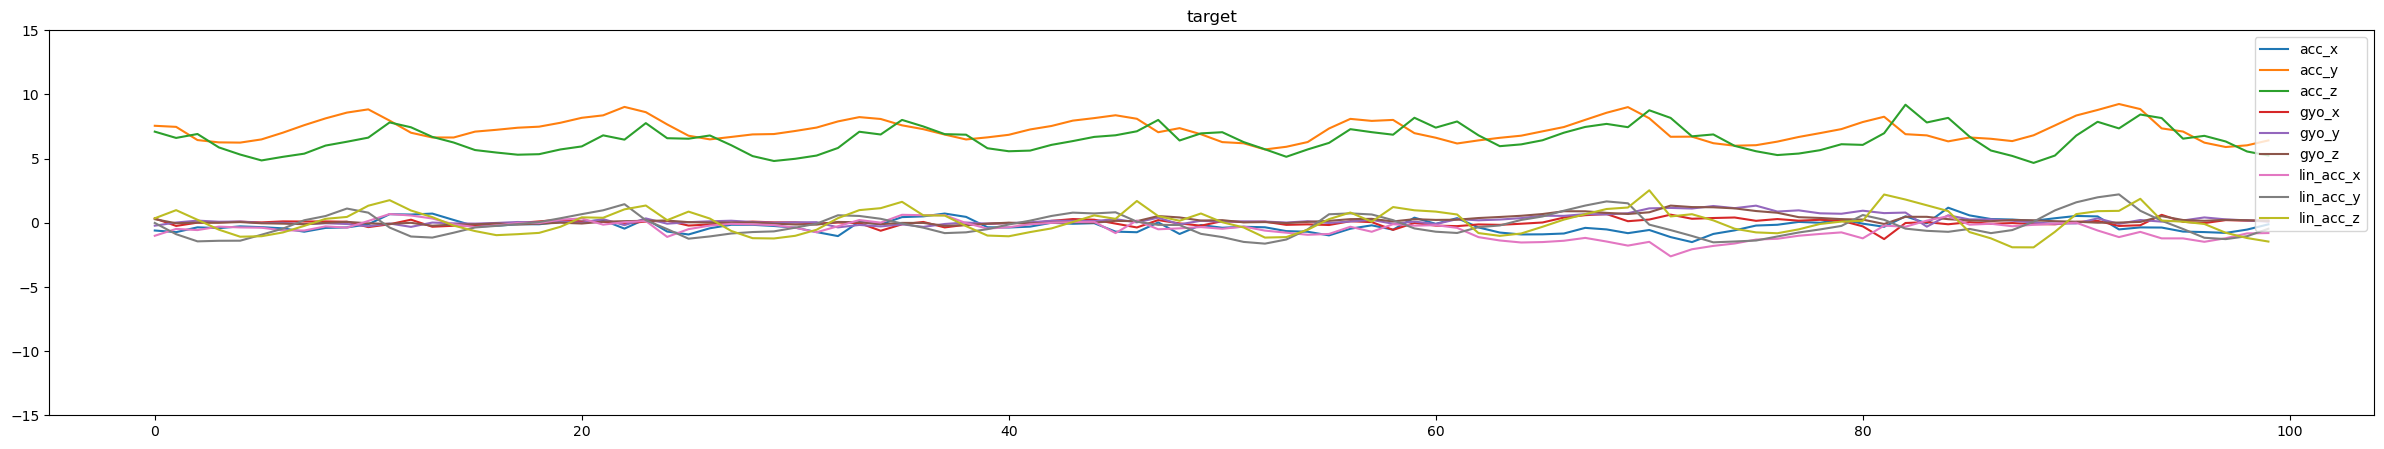

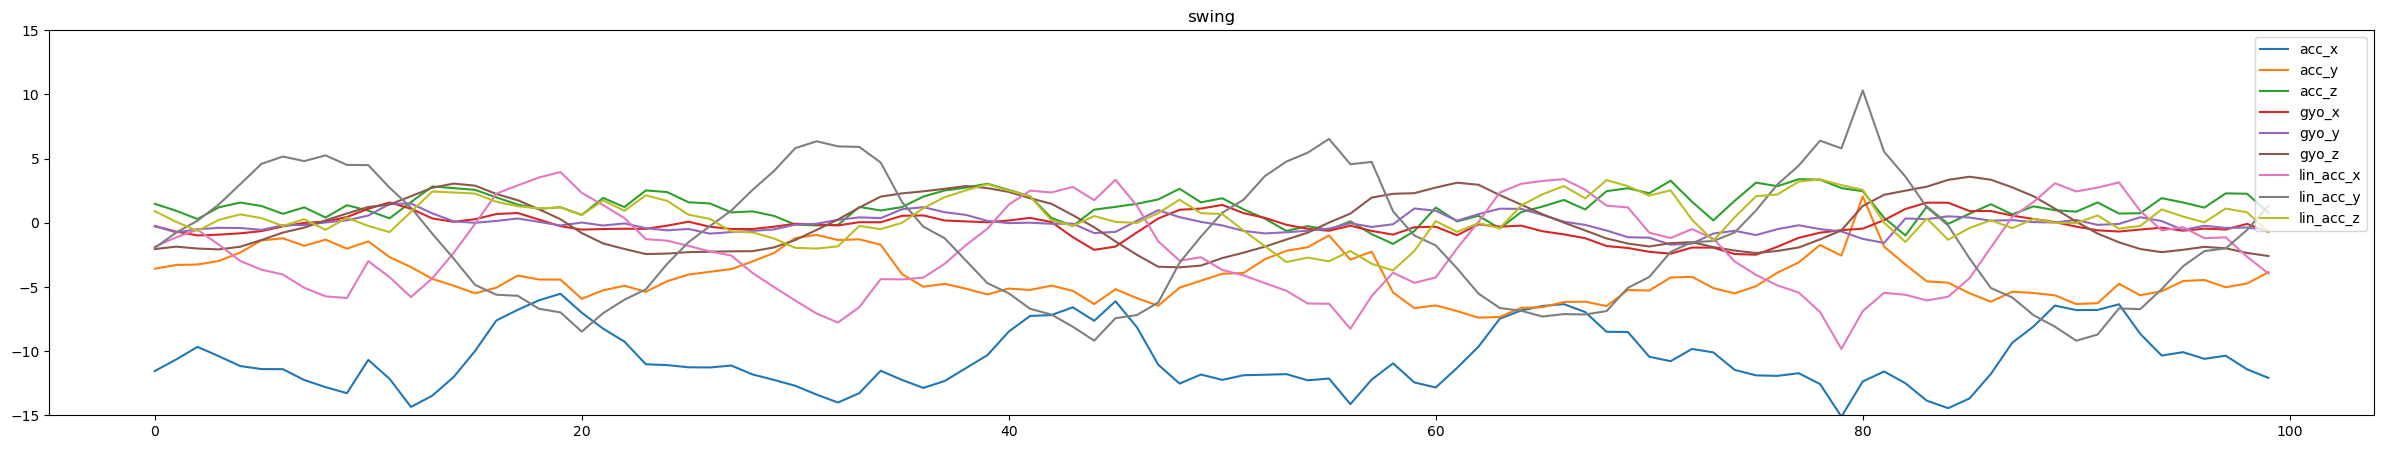

In [35]:
plot_curve(front_pocket_pair_data[0][2], 'target')
plot_curve(front_pocket_pair_data[0][0], 'front pocket')

plot_curve(pocket_pair_data[0][2], 'target')
plot_curve(pocket_pair_data[0][0], 'pocket')

plot_curve(swing_pair_data[0][2], 'target')
plot_curve(swing_pair_data[0][0], 'swing')